In [1]:
import numpy as np
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Any
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from resources.OTHERS.models import paraboloid_model as simulator
from src.forward import forward_propagation

In [2]:
def sample_true_uncertainty_model_2d(N = 10, rng = np.random.default_rng()):
    xa = rng.normal(4.0, 0.5, size=(N, 2))   # aleatoric
    xe = np.tile([2.0, 0.0], (N, 1))         # epistemic (fixed, repeated)
    return np.hstack([xa, xe])

# generate data for the horse and pony show
N_emp = 200
theta_true_cloud = sample_true_uncertainty_model_2d(200)
xi_list_c3 = [-2.0]
observations_c3 = []
for xi in xi_list_c3:
    y_emp  = simulator(theta_true_cloud, xi)  # shape (100,1) per design
    observations_c3.append((y_emp, xi))

print(f"CASE 3 - designs: {len(observations_c3)} samples: {observations_c3[0][0].shape[0]}")


CASE 3 - designs: 1 samples: 200


In [3]:
class UM_theta:
    def __init__(self,a, b, xe1 = 2.0, xe2 = 0.0):
        self.a = 4.0 if a is None else a
        self.b = 0.5 if b is None else b
        self.xe1 = xe1
        self.xe2 = xe2

    def sample(self, n_samples=100):
        xa = np.random.normal(self.a, self.b, size=(n_samples, 2))   # aleatoric
        xe = np.tile([self.xe1, self.xe2], (n_samples, 1))         # epistemic (fixed, repeated)
        return np.hstack([xa, xe])

    def update(self,a,b, xe1, xe2):
        self.a = a
        self.b = b
        self.xe1 = xe1
        self.xe2 = xe2

class UniformPrior:
    def __init__(self, a=-10 , b=10, xe1=2.0, xe2=0.0):
        self.a = a
        self.b = b
        self.xe1 = xe1
        self.xe2 = xe2

    def sample(self, n_samples=100):
        xa = np.random.uniform(self.a, self.b, size=(n_samples, 2))   # aleatoric
        xe = np.tile([self.xe1, self.xe2], (n_samples, 1))         # epistemic (fixed, repeated)
        return np.hstack([xa, xe])

    def update(self, a, b, xe1, xe2):
        self.a = a
        self.b = b
        self.xe1 = xe1
        self.xe2 = xe2

In [4]:
# generate simulation from prior for a design xi0
N = 500_000
xi0 = 1.0 # assume first design was given
theta_uniform = UniformPrior(-20,20).sample(N)
xi_uniform = np.random.uniform(-1,1, (N,1)) *0 + xi0
Y_sim = simulator(theta_uniform,xi=xi_uniform)
df_sim = pd.DataFrame(np.hstack([xi_uniform, theta_uniform, Y_sim]), columns=['xc','xa1','xa2','xe1','xe2','y' ])

In [5]:
# generate empirical data from the unknown pdf
pdf_theta = UM_theta(a=4.0, b=0.5)
y, samples = forward_propagation(pdf_theta, simulator, xi=xi0, n_samples=500) # empirical data
D_emp = {'xi': xi0, 'y': y}

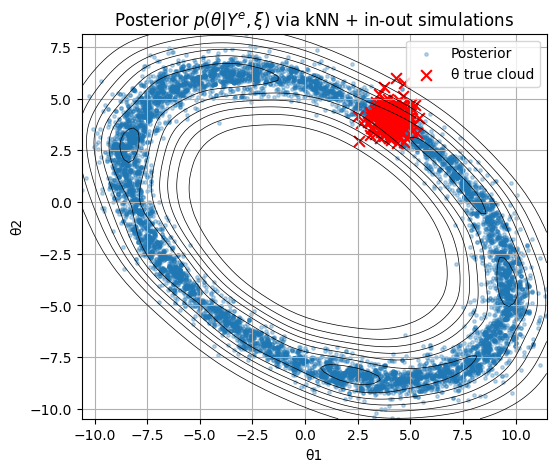

In [38]:
# perform calibration get posterior using the KNN calibrator
from src.plotting import plot_kde_2d
from src.knn import KNNCalibrator
import matplotlib.pyplot as plt
from src.plotting import scatter_post

simulated_data = {"y": Y_sim, "theta": theta_uniform[:,:2], "xi": xi_uniform}
# 'prep model
calib_comb = KNNCalibrator(knn=50, evaluate_model=False, a_tol=0.15)
calib_comb.setup(simulated_data=simulated_data, xi_list=[1.0])

obs = [(y.reshape(-1,1), xi0)]
post_reuse = calib_comb.calibrate(obs, combine="stack", resample_n=10000)
xa_posterior = post_reuse["theta"]

fig, ax = plt.subplots(figsize=(6,5))
scatter_post(ax, xa_posterior, truth=theta_true_cloud[:,:2],
             title=r"Posterior $p(\theta|Y^e,\xi)$ via kNN + in-out simulations ")
plot_kde_2d(xa_posterior[:,:2], true_theta=theta_true_cloud[:,:2], ax=ax)
plt.show()

In [14]:
# forward push to get simulated Y output for p(\theta|Y^e,\xi) and xi
xe = np.tile([2.0, 0.0], (np.shape(xa_posterior)[0], 1))         # epistemic (fixed, repeated)
theta_posterior = np.hstack([xa_posterior, xe])
y_post_xi0, samples_posterior_xi0 = forward_propagation(theta_posterior, simulator, xi=xi0, n_samples=500) # empirical data

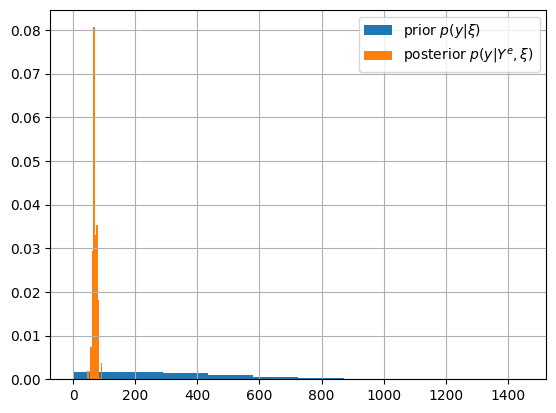

In [42]:
# compare conditional prior vs conditional posterior
plt.hist(Y_sim, density=True, label=r'prior $p(y|\xi)$')
plt.hist(y_post_xi0, density=True, label=r'posterior $p(y|Y^e, \xi)$')
plt.legend()
plt.grid()

In [25]:

import time
from scipy.spatial import cKDTree
from scipy.special import digamma

def simulate_y_from_xa(simulator, xa_samples, xi, xe_fixed=(2.0, 0.0)):
    """
    xa_samples: (N,2)
    returns y: (N,1)  (squeezed to (N,1) even if simulator returns (N,1,1))
    """
    xa = np.asarray(xa_samples, float)
    N = xa.shape[0]
    xe = np.tile(np.asarray(xe_fixed, float), (N, 1))
    theta_full = np.hstack([xa, xe])  # (N,4)
    xi_arr = np.full((N, 1), float(xi))
    y = np.asarray(simulator(theta_full, xi=xi_arr))
    y = np.squeeze(y)
    return y.reshape(N, 1)

def mi_kraskov(X, Y, k=20, seed=0, jitter=1e-10):
    """
    Kraskov kNN mutual information estimator for continuous variables.
    X: (N,dx), Y: (N,dy)
    Uses max-norm (L_infty) balls.
    """
    rng = np.random.default_rng(seed)
    X = np.asarray(X, float)
    Y = np.asarray(Y, float)
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]
    N = X.shape[0]
    assert Y.shape[0] == N

    # break ties / duplicates
    X = X + jitter * rng.standard_normal(X.shape)
    Y = Y + jitter * rng.standard_normal(Y.shape)

    Z = np.hstack([X, Y])
    treeZ = cKDTree(Z)
    treeX = cKDTree(X)
    treeY = cKDTree(Y)

    # distance to k-th neighbor in joint space (exclude self => query k+1)
    dists, _ = treeZ.query(Z, k=k+1, p=np.inf)
    eps = dists[:, k] - 1e-15  # strict radius

    nx = np.empty(N, dtype=int)
    ny = np.empty(N, dtype=int)
    for i in range(N):
        nx[i] = len(treeX.query_ball_point(X[i], eps[i], p=np.inf)) - 1
        ny[i] = len(treeY.query_ball_point(Y[i], eps[i], p=np.inf)) - 1

    return float(digamma(k) + digamma(N) - np.mean(digamma(nx + 1) + digamma(ny + 1)))


Next xi: -3.0
Diagnostics: {'n_eval': 10000, 'k_mi': 30, 'time_per_xi_s_mean': 0.9852520170718824, 'time_total_s': 40.395332699947176}


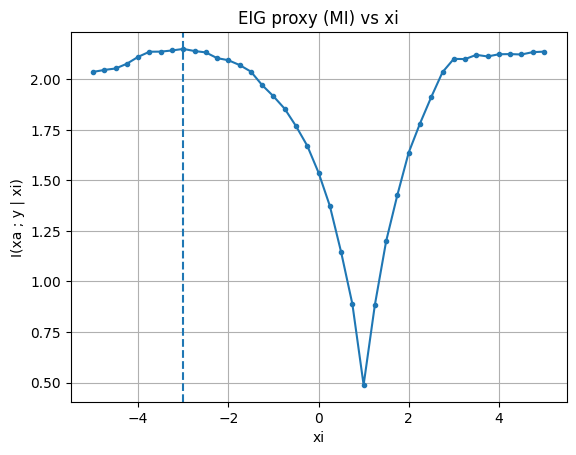

In [26]:
def select_next_xi_by_eig(
    simulator,
    xa_posterior,          # (M,2) samples from current belief p(xa | data)
    xi_candidates,         # list/array of candidate xi
    xe_fixed=(2.0, 0.0),
    n_eval=20000,          # subsample size used to score MI
    k_mi=20,
    seed=0
):
    rng = np.random.default_rng(seed)
    xa_posterior = np.asarray(xa_posterior, float)
    M = xa_posterior.shape[0]
    n_use = min(n_eval, M)
    idx = rng.choice(M, size=n_use, replace=False)
    Xa = xa_posterior[idx]

    scores = []
    times = []
    for xi in xi_candidates:
        t0 = time.perf_counter()
        y = simulate_y_from_xa(simulator, Xa, xi, xe_fixed=xe_fixed)  # (n_use,1)
        s = mi_kraskov(Xa, y, k=k_mi, seed=seed)
        times.append(time.perf_counter() - t0)
        scores.append(s)

    scores = np.asarray(scores, float)
    best_i = int(np.argmax(scores))
    diag = {
        "n_eval": n_use,
        "k_mi": k_mi,
        "time_per_xi_s_mean": float(np.mean(times)),
        "time_total_s": float(np.sum(times)),
    }
    return float(xi_candidates[best_i]), scores, diag


xi_candidates = np.linspace(-5, 5, 41)   # choose your design grid
xi_next, eig_scores, diag = select_next_xi_by_eig(
    simulator=simulator,
    xa_posterior=xa_posterior,
    xi_candidates=xi_candidates,
    xe_fixed=(2.0, 0.0),
    n_eval=20000,
    k_mi=30,
    seed=0
)

print("Next xi:", xi_next)
print("Diagnostics:", diag)


plt.figure()
plt.plot(xi_candidates, eig_scores, marker="o", markersize=3)
plt.axvline(xi_next, linestyle="--")
plt.title("EIG proxy (MI) vs xi")
plt.xlabel("xi")
plt.ylabel("I(xa ; y | xi)")
plt.grid(True)
plt.show()


In [30]:
import numpy as np
import time

def observe_empirical(pdf_theta_true, simulator, xi, n_emp, rng=None):
    """
    Query the real system (here: your UM_theta) at design xi.
    Returns y_emp with shape (n_emp, 1).
    """
    if rng is None:
        rng = np.random.default_rng()
    theta = pdf_theta_true.sample(n_emp)            # (n_emp, d_theta_full) e.g. (n,4)
    y = simulator(theta, xi)                        # allow scalar xi
    y = np.asarray(y)
    y = np.squeeze(y)
    return y.reshape(-1, 1)

def build_sim_db(pdf_theta_sim, simulator, xi_candidates, n_sim, rng=None):
    """
    Build simulated archive with xi varying across candidates.
    Returns simulated_data dict for KNNCalibrator.setup()
    """
    if rng is None:
        rng = np.random.default_rng()

    theta_sim = pdf_theta_sim.sample(n_sim)         # (n_sim, 4) here
    xi_vals = rng.choice(np.asarray(xi_candidates, float), size=n_sim, replace=True)
    xi_sim = xi_vals.reshape(-1, 1)                 # (n_sim,1)
    y_sim = simulator(theta_sim, xi=xi_sim)         # many codes use kw xi
    y_sim = np.asarray(y_sim)
    y_sim = np.squeeze(y_sim).reshape(-1, 1)

    return {"y": y_sim, "theta": theta_sim[:, :2], "xi": xi_sim}  # theta is xa only

def select_next_xi_by_eig_masked(
    simulator, xa_posterior, xi_candidates, used_xi,
    xe_fixed=(2.0, 0.0), n_eval=20000, k_mi=30, seed=0
):
    xi_next, scores, diag = select_next_xi_by_eig(
        simulator=simulator,
        xa_posterior=xa_posterior,
        xi_candidates=xi_candidates,
        xe_fixed=xe_fixed,
        n_eval=n_eval,
        k_mi=k_mi,
        seed=seed
    )

    # if selector returned a used xi (can happen on ties), pick best unused
    used = set(float(x) for x in used_xi)
    xi_candidates = np.asarray(xi_candidates, float)
    order = np.argsort(scores)[::-1]
    for j in order:
        cand = float(xi_candidates[j])
        if cand not in used:
            return cand, scores, diag
    return float(xi_next), scores, diag  # fallback


from src.knn import KNNCalibrator

def run_sequential_doe_knn(
    simulator,
    pdf_theta_true,        # UM_theta(...)  -> used to generate empirical data
    pdf_theta_sim,         # UniformPrior(...) -> used to build simulation archive
    xi0,                   # initial design (given)
    xi_candidates,         # grid/list of candidate designs for selection
    nq=5,                  # number of NEW experiments to do after xi0
    n_emp=200,             # replicates per empirical query
    n_sim=200_000,         # size of simulated archive
    knn=50,
    a_tol=0.15,
    combine="stack",       # recommend "stack" for stability
    resample_n=10_000,
    seed=0,
    n_eval_eig=20_000,
    k_mi=30,
):
    rng = np.random.default_rng(seed)
    xi_candidates = np.asarray(xi_candidates, float)
    xi_candidates = np.round(xi_candidates, 10)     # avoid float-key headaches
    xi0 = float(np.round(xi0, 10))

    # ---- build simulated archive over ALL candidate designs ----
    t0 = time.perf_counter()
    simulated_data = build_sim_db(pdf_theta_sim, simulator, xi_candidates, n_sim=n_sim, rng=rng)
    t_simdb = time.perf_counter() - t0

    # ---- setup calibrator once ----
    calib = KNNCalibrator(knn=knn, evaluate_model=False, a_tol=a_tol)
    calib.setup(simulated_data=simulated_data, xi_list=list(xi_candidates))

    # ---- initial empirical observation at xi0 ----
    t0 = time.perf_counter()
    y0 = observe_empirical(pdf_theta_true, simulator, xi0, n_emp=n_emp, rng=rng)
    t_emp0 = time.perf_counter() - t0

    observations = [(y0, xi0)]

    # ---- initial posterior ----
    t0 = time.perf_counter()
    post = calib.calibrate(observations, combine=combine, resample_n=resample_n)
    xa_post = post["theta"]
    t_cal0 = time.perf_counter() - t0

    history = {
        "xi": [xi0],
        "scores": [],          # EIG proxy curve per step
        "post": [xa_post],     # posterior samples per step
        "timing": {
            "simdb_s": t_simdb,
            "emp_s": [t_emp0],
            "cal_s": [t_cal0],
            "eig_s": [],
        },
        "meta": {
            "n_sim": n_sim, "n_emp": n_emp, "knn": knn, "a_tol": a_tol,
            "combine": combine, "resample_n": resample_n,
            "n_eval_eig": n_eval_eig, "k_mi": k_mi,
        }
    }

    used_xi = {xi0}

    # ---- sequential loop ----
    for q in range(nq):
        # 1) pick next xi by EIG/MI under current posterior
        t0 = time.perf_counter()
        xi_next, score_curve, diag_eig = select_next_xi_by_eig_masked(
            simulator=simulator,
            xa_posterior=xa_post,
            xi_candidates=xi_candidates,
            used_xi=used_xi,
            n_eval=n_eval_eig,
            k_mi=k_mi,
            seed=seed + 1000 + q,
        )
        t_eig = time.perf_counter() - t0

        # 2) collect new empirical data at xi_next
        t0 = time.perf_counter()
        y_new = observe_empirical(pdf_theta_true, simulator, xi_next, n_emp=n_emp, rng=rng)
        t_emp = time.perf_counter() - t0

        observations.append((y_new, xi_next))

        # 3) update posterior given ALL collected data so far
        t0 = time.perf_counter()
        post = calib.calibrate(observations, combine=combine, resample_n=resample_n)
        xa_post = post["theta"]
        t_cal = time.perf_counter() - t0

        # book-keeping
        used_xi.add(xi_next)
        history["xi"].append(xi_next)
        history["scores"].append(score_curve)
        history["post"].append(xa_post)
        history["timing"]["eig_s"].append(t_eig)
        history["timing"]["emp_s"].append(t_emp)
        history["timing"]["cal_s"].append(t_cal)

        print(f"[q={q+1}/{nq}] xi_next={xi_next:.4f} | "
              f"EIG_time={t_eig:.2f}s emp_time={t_emp:.2f}s cal_time={t_cal:.2f}s "
              f"| post_n={xa_post.shape[0]}")

    return history


In [31]:
xi_candidates = np.linspace(-5, 5, 41)

pdf_theta_true = UM_theta(a=4.0, b=0.5)        # “real” uncertainty model
pdf_theta_sim  = UniformPrior(a=-20, b=20)     # simulator archive prior

hist = run_sequential_doe_knn(
    simulator=simulator,
    pdf_theta_true=pdf_theta_true,
    pdf_theta_sim=pdf_theta_sim,
    xi0=1.0,
    xi_candidates=xi_candidates,
    nq=5,
    n_emp=200,
    n_sim=250_000,
    knn=50,
    a_tol=0.15,
    combine="stack",       # strongly recommended over intersect for stability
    resample_n=10_000,
    n_eval_eig=20_000,
    k_mi=30,
    seed=0
)


[q=1/5] xi_next=-2.7500 | EIG_time=35.57s emp_time=0.00s cal_time=18.87s | post_n=10000
[q=2/5] xi_next=-0.7500 | EIG_time=18.48s emp_time=0.00s cal_time=34.11s | post_n=10000
[q=3/5] xi_next=-4.0000 | EIG_time=30.73s emp_time=0.00s cal_time=76.97s | post_n=10000
[q=4/5] xi_next=-4.7500 | EIG_time=24.72s emp_time=0.00s cal_time=61.69s | post_n=10000
[q=5/5] xi_next=-4.5000 | EIG_time=30.09s emp_time=0.00s cal_time=76.21s | post_n=10000


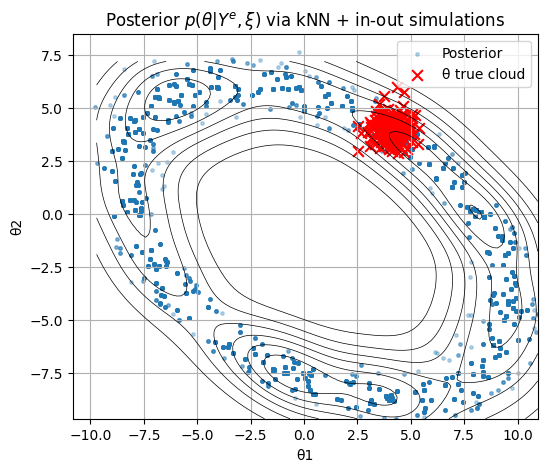

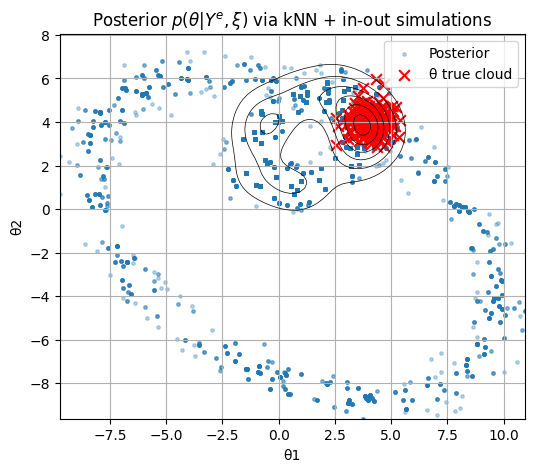

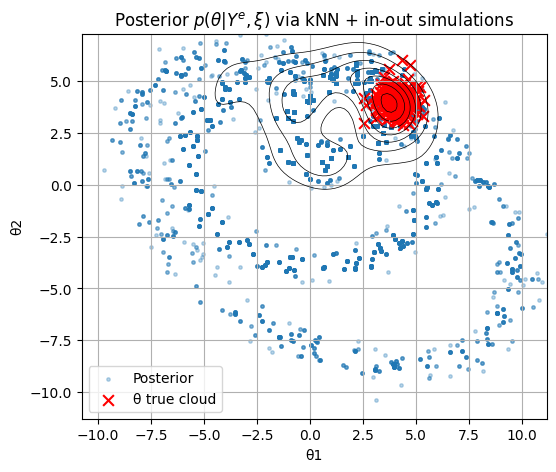

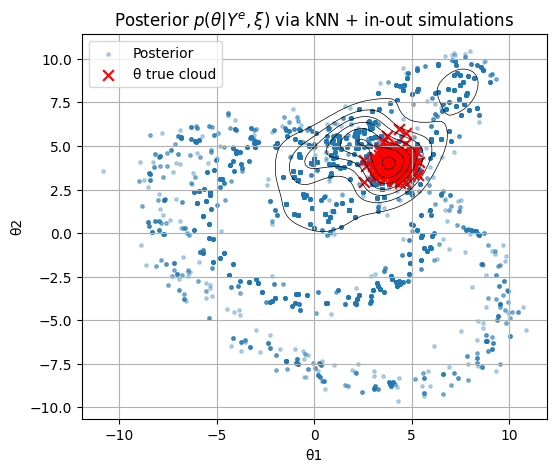

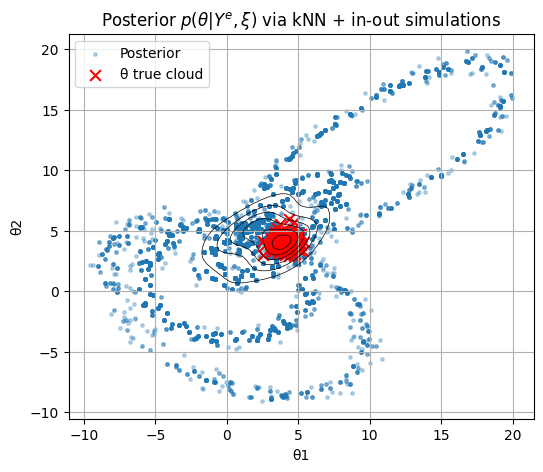

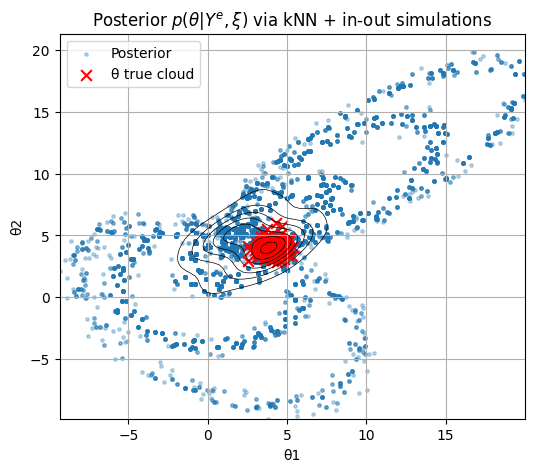

In [41]:
for post_xa_i in hist['post']:

    fig, ax = plt.subplots(figsize=(6,5))
    scatter_post(ax, post_xa_i, truth=theta_true_cloud[:,:2],
                 title=r"Posterior $p(\theta|Y^e,\xi)$ via kNN + in-out simulations ")
    plot_kde_2d(post_xa_i[:2500,:2], true_theta=theta_true_cloud[:,:2], ax=ax)
    plt.show()

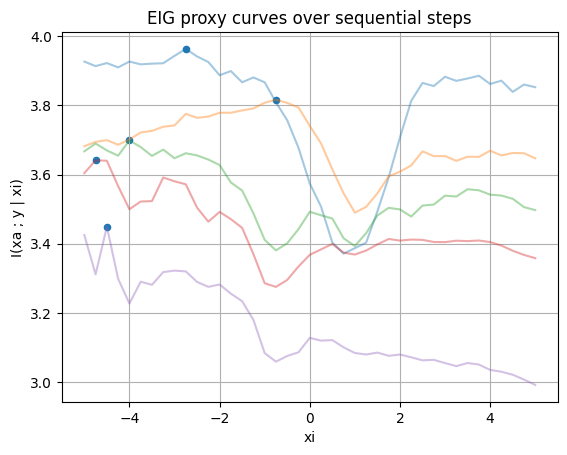

chosen xis: [1.0, -2.75, -0.75, -4.0, -4.75, -4.5]
timing: {'simdb_s': 0.05225740000605583, 'emp_s': np.float64(0.0010675999947125092), 'cal_s': np.float64(275.4363222999964), 'eig_s': np.float64(139.58443049999187)}


In [32]:
# quick diagnostic plots
xi_candidates = np.asarray(np.linspace(-5,5,41), float)

plt.figure()
for q, sc in enumerate(hist["scores"], start=1):
    plt.plot(xi_candidates, sc, alpha=0.4)
plt.scatter(hist["xi"], [max(s) if i>0 else np.nan for i,s in enumerate([None]+hist["scores"])],
            s=20)
plt.title("EIG proxy curves over sequential steps")
plt.xlabel("xi")
plt.ylabel("I(xa ; y | xi)")
plt.grid(True)
plt.show()

print("chosen xis:", hist["xi"])
print("timing:", {k: (np.sum(v) if isinstance(v, list) else v) for k,v in hist["timing"].items()})


# Tasks:
Use the available information to select new design set (set of points) $X_c = \{ x_{c,q}, ~ q=1,...,n_q \}$, up to a maximum experimental budget $n_q$, from which to collect new model responses to maximize uncertainty reduction in $x_e, x_a$.Each query generates a new empirical data set besides the $q=0$ which is already available.

* **CASE 1** Sequential design --> Assume we can query $q=1,...,n_q$ sequentially.

* **CASE 2** Non-sequential design --> Assume we select $q=1,...,n_q$ jointly and then gather data all in once.



## Optimal Design of Experiments Formulation

Let $x = (x_a, x_e, x_c)$, where $x_a$ are aleatoric variables, $x_e$ epistemic parameters, and
$x_c$ design variables. Let $y$ denote the observed system response.
We use $p(\cdot)$ to denote probability density functions.
The superscript $(q)$ indicates conditioning on the design $x_{c,q}$.

---

### CASE 2: Non-sequential (batch) experimental design

Let $X_c = \{ x_{c,1}, \ldots, x_{c,n_q} \}$ be a batch of design points.

#### CASE 2A: Conditional independence assumption

Assume that the observations $\{y_q\}_{q=1}^{n_q}$ are conditionally independent given
$x_e$ and $x_a$, i.e.

$$
p(y_{1:n_q} \mid x_e, x_a, X_c)
= \prod_{q=1}^{n_q} p(y_q \mid x_e, x_a, x_{c,q}).
$$

The batch design problem is formulated as maximization of the total expected information gain:

$$
X_c^\star
= \arg\max_{X_c}
\sum_{q=1}^{n_q}
\mathbb{E}_{p(y \mid x_{c,q})}
\left[
D_{\mathrm{KL}}
\left(
p(x_e \mid y, x_{c,q})
\;\|\;
p(x_e)
\right)
\right].
$$

Equivalently, using the joint expectation form:

$$
X_c^\star
= \arg\max_{X_c}
\sum_{q=1}^{n_q}
\mathbb{E}_{p(x_e)}
\mathbb{E}_{p(x_a)}
\mathbb{E}_{p(y \mid x_e, x_a, x_{c,q})}
\left[
\log
\frac{
p(y \mid x_e, x_{c,q})
}{
p(y \mid x_{c,q})
}
\right].
$$

---

#### CASE 2B: No independence assumption (joint entropy formulation)

If the observations are not conditionally independent, the batch design must be optimized
jointly by maximizing the mutual information between $x_e$ and the full observation vector
$y_{1:n_q}$:

$$
X_c^\star
= \arg\max_{X_c}
I(x_e ; y_{1:n_q} \mid X_c).
$$

This can be written explicitly as:

$$
X_c^\star
= \arg\max_{X_c}
\mathbb{E}_{p(x_e)}
\mathbb{E}_{p(y_{1:n_q} \mid x_e, X_c)}
\left[
\log
\frac{
p(y_{1:n_q} \mid x_e, X_c)
}{
p(y_{1:n_q} \mid X_c)
}
\right].
$$

This formulation accounts for dependencies across designs and does not decompose into
independent contributions.

---

### CASE 1: Sequential experimental design

Let $\mathcal{D}^{\mathrm{emp}}_{1:q-1}$ denote the empirical data collected up to step $q-1$.
At iteration $q$, the next design point is selected by maximizing the one-step expected
information gain:

$$
x_{c,q}^\star
=
\arg\max_{x_c \in \mathcal{X}_c}
\mathbb{E}_{p(y \mid x_c, \mathcal{D}^{\mathrm{emp}}_{1:q-1})}
\left[
D_{\mathrm{KL}}
\left(
p(x_e \mid y, x_c, \mathcal{D}^{\mathrm{emp}}_{1:q-1})
\;\|\;
p(x_e \mid \mathcal{D}^{\mathrm{emp}}_{1:q-1})
\right)
\right].
$$

Equivalently:

$$
x_{c,q}^\star
=
\arg\max_{x_c}
\mathbb{E}_{p(x_e)}
\mathbb{E}_{p(x_a)}
\mathbb{E}_{p(y \mid x_e, x_a, x_c)}
\left[
\log
\frac{
p(y \mid x_e, x_c)
}{
p(y \mid x_c)
}
\right].
$$

After querying the system at $x_{c,q}^\star$, the posterior distribution of $x_e$ is updated,
and the procedure is repeated until the experimental budget is exhausted.

